<a href="https://colab.research.google.com/github/TeachingTextMining/TextClassification/blob/main/03-SA-Transformers-Training-FineTuning/03-TextClassification-with-Transformers-FineTuning-Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clasificación de textos utilizando Transformers. Entrenando nuestro propio modelo


La clasificación de textos consiste en, dado un texto, asignarle una entre varias categorías. Algunos ejemplos de esta tarea son:

- dado un tweet, categorizar su connotación como positiva, negativa o neutra.
- dado un post de Facebook, clasificarlo como portador de un lenguaje ofensivo o no.  

En la figura se muestra una arquitectura típica de un sistema de aprendizaje automático para resolver esta tarea.

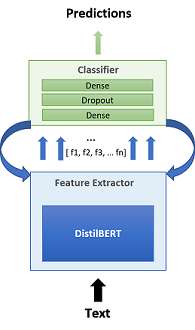

En la actividad exploraremos cómo utilizar la librería [Transformers](https://huggingface.co/transformers/) para construir este modelo y entrenarlo para clasificar reviews de [IMDB](https://www.imdb.com/) sobre películas en las categorías \[$positive$, $negative$\]. 

Puede encontrar más información sobre este problema en [Kaggle](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) y en [Large Movie Review Datase](http://ai.stanford.edu/~amaas/data/sentiment/). También consultar el tutorial sobre [Fine-tunning de modelos](https://huggingface.co/transformers/custom_datasets.html#seq-imdb) en la web del proyecto  Transformers.

**Instrucciones:**

- siga las indicaciones y comentarios en cada apartado.


**Después de esta actividad nos habremos familiarizado con:**

- la arquitectura de un modelo para clasificar textos basado en Transformers.

- el re-entrenamiento de modelos para la clasificación de secuencias.

- aspectos importantes a tener en cuenta como el formato de los datos para entrenar y realizar nuevas predicciones.

**Requerimientos**
- python 3.6.12 - 3.8
- tensorflow==2.3.0
- transformers==4.2.1
- pandas==1.1.5
- plotly==4.13.0
- tqdm==4.56.0
- scikit-learn==0.24.0

**Note que:** en dependencia del entorno de ejecución, puede ser necesario instalar manualmente alguno de estos paquetes.



<a name="sec:setup"></a>
### Instalación de librerías e importación de dependencias.

Para comenzar, es preciso instalar las dependencias, realizar los imports necesarios y definir algunas funciones auxiliares.

Ejecute las siguientes casillas prestando atención a las instrucciones adicionales en los comentarios.

In [ ]:
# instalar librerías. Esta casilla es últil por ejemplo si se ejecuta el cuaderno en Google Colab
# Note que existen otras dependencias como tensorflow, etc. que en este caso se encontrarían ya instaladas
%%capture
!pip install transformers==4.2.1

print('Done!')

In [ ]:
# reset environment
%reset -f

# para establecer caminos al guardar y leer archivos
import os

# para cargar datos y realizar pre-procesamiento básico
import pandas as pd
from collections import Counter
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_class_weight

# para evaluar los modelos 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels

#  para construir gráficas y realizar análisis exploratorio de los datos
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
from tqdm import tqdm

# para guardar el modelo
import pickle
import tensorflow as tf

# algoritmos de clasificación, tokenizadores, etc.
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, ModelCard, DistilBertConfig, TextClassificationPipeline

print('Done!')

In [ ]:
# función auxiliar para obtener tensores de entrada al modelo a partir del texto
def get_model_inputs(cfg, data):
    # obtener ids y máscaras para el conjunto de entrenamiento
    # no es necesario convertir a tensores porque la salida del tokenizador se encuentra en este formato, 
    encodings = cfg['tokenizer'](data, truncation=True, padding='max_length', max_length=cfg['max_length'], return_tensors=cfg['framework'])

    # formatear los datos (tensores) de entrada de acuerdo con las opciones permitidas por TensorFlow
    # los nombres de las capas de Input creadas al construir el modelo ('input_ids', 'attention_mask', 'tfidf') 
    # son utilizados como llaves en los diccionarios que representan las entradas al modelo
    inputs = {'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask']
            }
    return inputs

# función auxiliar para realizar predicciones con el modelo
def predict_model(model, cfg, data, pref='m'):
  """
  data: list of the text to predict
  pref: identificador para las columnas (labels_[pref], scores_[pref]_[class 1], etc.)
  """
  res = {}
  inputs = get_model_inputs(cfg, data)
  scores = model.predict(inputs)['logits']  # la salida de este modelo es TFSequenceClassifierOutput, debe tomarse el valor asociado a la llave 'logits'
  
  # empaquetar scores dentro de un diccionario que contiene labels, scores clase 1, scores clase 2, .... El nombre de la clase se normaliza a lowercase
  if cfg['num_labels']==1: # si es clasificación binaria, este modelo devuelve solo 1 score por instancia
    res = {f'scores_{pref}': scores[:,0]}
  else:
    res = {f'scores_{pref}_{cls.lower()}': score for cls, score in zip(cfg['label_binarizer'].classes_, [col for col in scores.T])}

  # añadir datos relativos a la predicción
  labels = cfg['label_binarizer'].inverse_transform(scores)
  res[f'labels_{pref}'] = labels

  # convertir a dataframe ordenando las columnas primero el label y luego los scores por clase, las clases ordenadas alfabeticamente
  res = pd.DataFrame(res, columns=sorted(list(res.keys())))
  return res


# función auxiliar que evalúa los resultados de una clasificación
def evaluate_model(y_true, y_pred, y_score=None, pos_label='positive'):
  print('==== Sumario de la clasificación ==== ')
  print(classification_report(y_true, y_pred))

  print('Accuracy -> {:.2%}\n'.format(accuracy_score(y_true, y_pred)))

  # graficar matriz de confusión
  display_labels = sorted(unique_labels(y_true, y_pred), reverse=True)
  cm = confusion_matrix(y_true, y_pred, labels=display_labels)

  z = cm[::-1]
  x = display_labels
  y =  x[::-1].copy()
  z_text = [[str(y) for y in x] for x in z]

  fig_cm = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

  fig_cm.update_layout(
      height=400, width=400,
      showlegend=True,
      margin={'t':150, 'l':0},
      title={'text' : 'Matriz de Confusión', 'x':0.5, 'xanchor': 'center'},
      xaxis = {'title_text':'Valor Real', 'tickangle':45, 'side':'top'},
      yaxis = {'title_text':'Valor Predicho', 'tickmode':'linear'},
  )
  fig_cm.show()


  # curva roc (definido para clasificación binaria)
  fig_roc = None
  if y_score is not None:
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=pos_label)
    fig_roc = px.area(
        x=fpr, y=tpr,
        title={'text' : f'Curva ROC (AUC={auc(fpr, tpr):.4f})', 'x':0.5, 'xanchor': 'center'},
        labels=dict(x='Ratio Falsos Positivos', y='Ratio Verdaderos Positivos'),
        width=400, height=400
    )
    fig_roc.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)

    fig_roc.update_yaxes(scaleanchor="x", scaleratio=1)
    fig_roc.update_xaxes(constrain='domain')
    
    fig_roc.show()

print('Done!')

### Carga de datos y análisis exploratorio

El primer paso consiste en obtener los datos relacionados con nuestra tarea dejándolos en el formato adecuado.  Existen diferentes opciones, entre estas:

- montar nuestra partición de Google Drive y leer un fichero desde esta.

- leer los datos desde un fichero en una carpeta local.

- leer los datos directamente de un URL.

En este caso, se encuentran en un fichero separado por comas con la siguiente estructura:

| Phrase | Sentiment| 
| ------ | ------ |
| This movie is really not all that bad...    | positive |


Ejecute la siguiente casilla para leer los datos.



In [ ]:
# descomente las siguientes 3 líneas para leer datos desde Google Drive, asumiendo que se trata de un fichero llamado review.csv localizado dentro de una carpeta llamada 'Datos' en su Google Drive
#from google.colab import drive
#drive.mount('/content/drive')
#path = '/content/drive/MyDrive/Datos/ejemplo_review_train.csv'

# descomente la siguiente línea para leer los datos desde un archivo local, por ejemplo, asumiendo que se encuentra dentro de un directorio llamado sample_data
#path = './sample_data/ejemplo_review_train.csv'

# descomente la siguiente línea para leer datos desde un URL
path = 'https://github.com/TeachingTextMining/TextClassification/raw/main/03-SA-Transformers-Training-FineTuning/sample_data/ejemplo_review_train.csv'

# leer los datos
data = pd.read_csv(path, sep=',')

print('Done!')

Una vez leídos los datos, ejecute la siguiente casilla para construir una gráfica que muestra la distribución de clases en el corpus.

In [ ]:
text_col = 'Phrase'  # columna del dataframe que contiene el texto (depende del formato de los datos)
class_col = 'Sentiment'  # columna del dataframe que contiene la clase (depende del formato de los datos)

# obtener algunas estadísticas sobre los datos
categories = sorted(data[class_col].unique(), reverse=False)
hist= Counter(data[class_col]) 
print(f'Total de instancias -> {data.shape[0]}')
print(f'Distribución de clases -> {{item[0]:round(item[1]/len(data[class_col]), 3) for item in sorted(hist.items(), key=lambda x: x[0])}}')

print(f'Categorías -> {categories}')
print(f'Comentario de ejemplo -> {data[text_col][0]}')
print(f'Categoría del comentario -> {data[class_col][0]}')

fig = go.Figure(layout=go.Layout(height=400, width=600))
fig.add_trace(go.Bar(x=categories, y=[hist[cat] for cat in categories]))
fig.show()

print('Done!')

Finalmente, ejecute la siguiente casilla para crear los conjuntos de entrenamiento y validación que se utilizarán para entrenar y validar los modelos.

In [ ]:
# obtener conjuntos de entrenamiento (90%) y validación (10%)
seed = 0  # fijar random_state para reproducibilidad
train, val = train_test_split(data, test_size=.1, stratify=data[class_col], random_state=seed)

print('Done!')

### Implementación y configuración del modelo

Como hemos visto, la arquitectura del modelo consta de:

- un extractor de rasgos con los que se describirá el texto. En nuestro caso, se utilizará una versión pre-entrenada de [DistilBERT](https://huggingface.co/transformers/model_doc/distilbert.html).

- un clasificador que aprenderá a partir de un conjunto de ejemplos donde cada texto se representa a partir de los rasgos. En la actividad, el clasificador será una red neuronal.

En la actividad, aprovecharemos una implementación de esta arquitectura incluida en Transformers mediante la clase [TFDistilBertForSequenceClassification](https://huggingface.co/transformers/model_doc/distilbert.html#tfdistilbertforsequenceclassification). 

Es decir, partiremos de un modelo pre-entrenado en datos diferentes a los nuestros (transfer-learning) realizando algunas iteraciones adicionales para ajustarlo a nuestro problema en particular (fine-tuning).

Una ventaja de este enfoque es que, tanto el extractor como el clasificador se entrenarán conjuntamente para modelar nuestro problema.


**Notar que:**

- en un problema de clasificación multiclases la última capa densa del clasificador debe tener tantas neuronas como posibles categorías contemple el problema. No obstante, en un problema de clasificación binaria, es recomendable tener una sola neurona. Ver *num_labels* en la configuración de DistilBERT.

- los modelos que implementa Transformers funcionan como modelos [Keras](https://www.tensorflow.org/guide/keras?hl=es) por lo que al utilizarlos debe cuidarse que las entradas tengan el número y formato adecuado. En este caso, deben suministrarse tensores correspondientes al texto tokenizado y las respectivas attention masks.

Ejecute las siguientes casillas prestando atención a los comentarios incluidos junto al código.


In [ ]:
# configuraciones
cfg = {}  # diccionario para agrupar configuraciones y variables para su posterior uso
cfg['framework'] = 'tf'  # TensorFlow como framework (por cuestiones del formato en los datos)
cfg['max_length'] = 512  # máxima longitud de secuencia recomendada por DistilBERT
cfg['transformer_model_name'] = 'distilbert-base-uncased'
cfg['num_labels'] = 1  # cambiar este número según el número de clases

print('Done!')

#### Configuración del modelo

In [ ]:
# configuraciones
config = DistilBertConfig(num_labels=cfg['num_labels'], seq_classif_dropout=0.5)

# cargar el modelo pre-entrenado disponible en Transformers
model = TFDistilBertForSequenceClassification.from_pretrained(cfg['transformer_model_name'], config=config)

# finalizar configuración del modelo
# se sugiere revisar documentación para más detalles sobre los diferentes hiper-parámetros
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

# definir función loss. Debe cuidarse que sea coherente con la salida esperada del modelo (vector de num_labels elementos)
# y el formato de los ejemplos (vector one-hot de num_labels componentes para codificar las categorías)
## para más de una categoría utilizar tf.keras.losses.CategoricalCrossentropy u otra a fin
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# compilar el modelo, indicando otras métricas que se desee monitorear.
# La métrica debe ser apropiada para el tipo de problema (clasificación binaria o multiclase)
## para más de una categoría utilizar 'categorical_accuracy'
model.compile(optimizer=optimizer, loss=loss, metrics=['binary_accuracy'])

# imprimir sumario del modelo
model.summary()

print('Done!')

### Pre-procesamiento de los datos

Antes de entrenar, debemos pre-procesar los datos. Esto dependerá de la tarea en particular, en este caso, comprende:

- tokenizar para obtener los ids y las máscaras. Debe tener en cuenta que el tokenizador debe ser compatible con el modelo a utilizar, DistilBERT en este caso.

- obtener los vectores one-hot correspondientes a las categorías.

- convertir a tensores cuando sea necesario, pues este será el formato de entrada que se utilizará en el modelo. Los tensores representan una estructura multidimensional de Tensorflow para contener los datos.

**Notar que:**
- es necesario codificar el valor correspondiente a la categoría de modo que pueda procesarse por la red neuronal. Podemos asignar valor *1* a la categoría *positive* y *0* a la *negative*.  En un problema de clasificación multiclases, podemos realizar la codificación mediante un vector one-hot. En la actividad utilizaremos [LabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) de [scikit-learn](https://scikit-learn.org/stable/).

Ejecute las siguiente casillas prestando atención a los comentarios explicativos.

#### Instanciar tokenizador, etc.

In [ ]:
# cargar el tokenizador, disponible en Transformers
cfg['tokenizer'] = DistilBertTokenizer.from_pretrained(cfg['transformer_model_name'] )

# instanciar y entrenar LabelBinarizer
cfg['label_binarizer'] = preprocessing.LabelBinarizer() # guardar para su posterior uso al decodificar predicciones

print('Done!')

#### Pre-procesamiento

In [ ]:
# entrenar LabelBinarizer
cfg['label_binarizer'].fit(train[class_col])

# guardar LabelBinarizer para su uso posterior (decodificar las predicciones de nuevos datos)
with open('label_binarizer_reviews.pkl', 'wb') as f:
    pickle.dump(cfg['label_binarizer'], f)

# obtener codificación one-hot
train_blabels = cfg['label_binarizer'].transform(train[class_col])
val_blabes = cfg['label_binarizer'].transform(val[class_col])

# obtener tensores correspondientes
train_blabels_t = tf.convert_to_tensor(train_blabels, dtype='int32')
val_blabels_t = tf.convert_to_tensor(val_blabes, dtype='int32')

# obtener diccionarios representando las entradas del modelo
train_inputs = get_model_inputs(cfg, train[text_col].to_list())
val_inputs = get_model_inputs(cfg, val[text_col].to_list())

print('Done!')

### Entrenamiento del modelo

Por último, es necesario entrenar el modelo.

**Notar que:**
 - la ejecución puede tomar un tiempo considerable (horas) o fallar por falta de memoria en dependencia del hardware y parámetros como el *batch_size*.

- es recomendable guardar checkpoints del modelo luego de varias iteraciones. En este caso, se guardarán en carpeta con nombres tipo "distilbert-reviews-epochs-[epoch_from]-[epoch_to]", por ejemplo, "distilbert-reviews-epochs-[003]-[003]".

In [ ]:
# configuraciones
cfg['checkpoints_dir'] = 'checkpoints'  # directorio donde se guardarán los checkpoints al entrenar el modelo
cfg['model_name'] = 'distilbert-reviews'  # identificador al guardar los checkpoints
cfg['trained_model_name'] = os.path.join(cfg['checkpoints_dir'], cfg['model_name'])

epochs_max = 1
epochs_to_save = 1
batch_size = 16

# ciclo de entrenamiento y guardar checkpoints
for epoch in tqdm(range(0, epochs_max, epochs_to_save)):
    print(f'Training model, epochs {epoch+1} - {epoch+epochs_to_save}')
    
    # entrenar el modelo. Opcionalmente, se puede suministrar datos de validación => validation_data=(val_inputs,val_blabels_t )
    model.fit(train_inputs, y=train_blabels_t, epochs=epochs_to_save, batch_size=batch_size, validation_data=(val_inputs,val_blabels_t))

    model.save_pretrained(cfg['trained_model_name'] + f'-epochs-{epoch+1:03d}-{epoch+epochs_to_save:03d}')
    cfg['tokenizer'].save_pretrained(cfg['trained_model_name'] + f'-epochs-{epoch+1:03d}-{epoch+epochs_to_save:03d}')

print('Done!')

### Evaluación del modelo
Luego de entrenado el modelo, podemos evaluar su desempeño en los conjuntos de entrenamiento y validación.

Ejecute la siguiente casilla para evaluar el modelo en el conjunto de entrenamiento.

In [ ]:
# predecir los datos de entrenamiento
data = train
true_labels = data[class_col]

m_pred = predict_model(model, cfg, data[text_col].to_list(), pref='m')

evaluate_model(true_labels, m_pred['labels_m'])  # notar que en este caso se no suministran los scores

print('Done!')

Ejecute la siguiente casilla para evaluar el modelo en el conjunto de validación. Compare los resultados.

In [ ]:
# predecir los datos de validación
data = val
true_labels = data[class_col]

m_pred = predict_model(model, cfg, data[text_col].to_list(), pref='m')

evaluate_model(true_labels, m_pred['labels_m'])  # notar que en este caso se no suministran los scores

print('Done!')

## Predicción de nuevos datos

Una vez entrenado el modelo, podemos evaluar su rendimiento en datos no utilizados durante el aprendizaje o emplearlo para predecir nuevas instancias. En cualquier caso, se debe cuidar realizar los pasos de pre-procesamiento necesarios según el caso. En el ejemplo, utilizaremos la porción de prueba preparada inicialmente.

**Notar que**:
-  se cargará el modelo previamente entrenado, estableciendo las configuraciones pertinentes.

- se debe decodificar la salida del modelo para obtener la correspondiente categoría utilizando el mismo codificador.

- si disponemos de un modelo guardado, podremos ejecutar directamente esta parte del cuaderno. Sin embargo, será necesario al menos ejecutar previamente la sección [**Instalación de librerías...**](#sec:setup)



### Cargar otros elementos necesarios 

Antes de predecir nuevos datos, también es preciso cargar otros elementos necesarios como el tokenizador, el codificador para las etiquetas, etc.

Ejecute la siguiente casilla.

In [ ]:
# configuraciones
text_col = 'Phrase'  # columna del dataframe que contiene el texto (depende del formato de los datos)
class_col = 'Sentiment'  # columna del dataframe que contiene la clase (depende del formato de los datos)

cfg = {}  # diccionario para agrupar configuraciones y variables para su posterior uso
cfg['framework'] = 'tf'  # TensorFlow como framework (por cuestiones del formato en los datos)
cfg['max_length'] = 512  # máxima longitud de secuencia recomendada por DistilBERT
cfg['transformer_model_name'] = 'distilbert-base-uncased'
cfg['num_labels'] = 1  # ver descripción de la sección "Implementación y configuración del modelo"

cfg['checkpoints_dir'] = 'checkpoints'
cfg['model_name'] = 'distilbert-reviews-epochs-001-001'
cfg['trained_model_name'] = os.path.join(cfg['checkpoints_dir'], cfg['model_name'])

# cargar el tokenizador (desde la carpeta del checkpoint)
cfg['tokenizer'] = DistilBertTokenizer.from_pretrained(cfg['trained_model_name'])

# cargar el codificador one-hot utilizado para codificar los datos de entrenamiento
# es necesario para realizar la transformación inversa de la salida de la red y conocer el número de categorías
with open('label_binarizer_reviews.pkl', 'rb') as f:
    cfg['label_binarizer'] = pickle.load(f)

print('Done!')

### Instanciar modelo pre-entrenado

Para predecir nuevas instancias es preciso cargar el modelo previamente entrenado. Esto dependerá del formato en el que se exportó el modelo, pero en general se requieren dos elementos: la estructura del modelo y los pesos. 

Ejecute la siguiente casilla para cargar el modelo.

In [ ]:
config = DistilBertConfig(num_labels=cfg['num_labels'])

# cargar modelo entrenado para evaluarlo o predecir nuevos datos
model = TFDistilBertForSequenceClassification.from_pretrained(cfg['trained_model_name'], config=config)

print('Done!')

### Predecir nuevos datos

Con el modelo y el tokenizador cargados, es posible utilizarlo para analizar nuevos datos. 

Ejecute las siguientes casillas para:

(a) categorizar un texto de muestra.

(b) cargar nuevos datos, categorizarlos y mostrar algunas estadísticas sobre el corpus.

In [ ]:
# ejemplo de texto a clasificar, # lista [texto 1, text 2, ..., texto n]
text = ['Brian De Palma\'s undeniable virtuosity can\'t really camouflage the fact that his plot here is a thinly disguised\
        \"Psycho\" carbon copy, but he does provide a genuinely terrifying climax. His "Blow Out", made the next year, was an improvement.']

m_pred = predict_model(model, cfg, text, pref='m')

pred_labels = m_pred['labels_m'].values[0]
pred_proba = m_pred['scores_m'].values[0]

print(f'La categoría de la frase es -> {pred_labels}')
print(f'El score asignado a la clase positiva es -> {pred_proba:.2f}')

print('Done!')


También podemos predecir nuevos datos cargados desde un fichero. 

Ejecute la siguiente casilla, descomentando las instrucciones necesarias según sea el caso.

In [ ]:
# descomente las siguientes 3 líneas para leer datos desde Google Drive, asumiendo que se trata de un fichero llamado review.csv localizado dentro de una carpeta llamada 'Datos' en su Google Drive
#from google.colab import drive
#drive.mount('/content/drive')
#path = '/content/drive/MyDrive/Datos/ejemplo_review_train.csv'

# descomente la siguiente línea para leer los datos desde un archivo local, por ejemplo, asumiendo que se encuentra dentro de un directorio llamado sample_data
#path = './sample_data/ejemplo_review_train.csv'

# descomente la siguiente línea para leer datos desde un URL
path = 'https://github.com/TeachingTextMining/TextClassification/raw/main/03-SA-Transformers-Training-FineTuning/sample_data/ejemplo_review_test.csv'

# leer los datos
new_data = pd.read_csv(path, sep=',')

print('Done!')

Ejecute la siguiente celda para predecir los datos y mostrar algunas estadísticas sobre el análisis realizado.

In [ ]:
# predecir los datos de prueba
m_pred = predict_model(model, cfg, new_data[text_col].to_list(), pref='m')
pred_labels = m_pred['labels_m']

# obtener algunas estadísticas sobre la predicción en el conjunto de pruebas
categories = sorted(pred_labels.unique(), reverse=False)
hist = Counter(pred_labels.values) 

fig = go.Figure(layout=go.Layout(height=400, width=600))
fig.add_trace(go.Bar(x=categories, y=[hist[cat] for cat in categories]))
fig.show()

print('Done!')